In [395]:
%load_ext line_profiler

In [457]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import time

from collections import Counter, defaultdict, OrderedDict, namedtuple
import random
import copy
import bisect
import heapq

In [2]:
import warnings
warnings.filterwarnings('default')

In [4]:
records = pd.read_csv('Webscope_R6B/ydata-fp-td-clicks-v2_0.20111002',
           sep=' ',
           names=['timestamp','id','clicked'],
           usecols=[0,1,2],
           )
records.head()

,timestamp,id,clicked
0,1317513291,id-560620,0
1,1317513291,id-565648,0
2,1317513291,id-563115,0
3,1317513292,id-552077,0
4,1317513292,id-564335,0


In [6]:
# parser that watches article lifespans
lifespans = {}
with open('Webscope_R6B/ydata-fp-td-clicks-v2_0.20111002') as f:
    for line in f.readlines():
        timestamp = int(line[:10])
        components = line.strip().split(' |')
        for article in components[2:]:
            if article in lifespans:
                lifespans[article][1] = timestamp
            else:
                lifespans[article] = [timestamp, timestamp]

In [426]:
class Arm:
    def __init__(self,lifespan):
        self.birth, self.death = lifespan
        self.T = 0
        self.rewards = 0
        self.X = -1
    def __repr__(self):
        return '{} {}/{} lifespan: {}'.format(self.X, self.rewards, self.T, (self.birth, self.death))
pool = {}
for k in lifespans:
    pool[k] = Arm(lifespans[k])
pool = OrderedDict(sorted(pool.items(), key=lambda i:i[1].death, reverse=True))

In [435]:
pool.keys()

odict_keys(['id-563643', 'id-563846', 'id-564418', 'id-565822', 'id-560805', 'id-564371', 'id-562265', 'id-566431', 'id-566439', 'id-559833', 'id-566541', 'id-562374', 'id-566587', 'id-566478', 'id-566573', 'id-566602', 'id-562637', 'id-566631', 'id-566689', 'id-566726', 'id-566825', 'id-566838', 'id-566022', 'id-555224', 'id-565515', 'id-555528', 'id-559855', 'id-560290', 'id-565648', 'id-566013', 'id-563582', 'id-565479', 'id-565533', 'id-565930', 'id-563115', 'id-560518', 'id-565589', 'id-565980', 'id-564335', 'id-565747', 'id-566092', 'id-565561', 'id-565364', 'id-560620', 'id-564604', 'id-563938', 'id-559744', 'id-563787', 'id-552077'])

In [ ]:
class Arm:
    def __init__(self,lifespan):
        self.birth, self.death = lifespan
        self.s = None
        self.l = None
        self.T = 0
        self.rewards = 0
        self.X = -1
    def __repr__(self):
        return '{} {}/{} lifespan: {}'.format(self.X, self.rewards, self.T, (self.birth, self.death))
unborn = {}
for k in lifespans:
    unborn[k] = Arm(lifespans[k])
pool = OrderedDict(sorted(pool.items(), key=lambda i:i[1].birth, reverse=True))

In [ ]:
class UCB_L:
    def __init__(self, records, pool):
        self.records = records.itertuples()
        self.rewards = 0
        self.pool = [] # heap: (death, id)
        self.arms = copy.deepcopy(pool) # ordered dict of arms
        self.unborn = list(pool.keys())
        self.avg_life = 0
        self.best = 'id-563643'
        self.X = 0
        
    def update(self, record):
        self.rewards += record.clicked
        self.pool[record.id].rewards += record.clicked
        self.pool[record.id].T += 1
        self.pool[record.id].X = self.pool[record.id].rewards / self.pool[record.id].T
        self.best = max((self.best, record.id), key= lambda arm:self.pool[arm].X)
        
    def initialize(self, m):
        for i in range(m):
            record = next(self.records) # raise StopIteration
            if not pool[record.id].T: # not played
                self.update(record)
    
    def play(self, n, c=1):
        def score(p):
            arm = self.arms[p[1]]
            if arm.T:
                T = arm.T
                X = arm.X
            else: # if it's never played, use estimation
                T = 1
                X = self.X
            return X + c*np.log(self.avg_life+arm.s-t+1) * np.sqrt(2*np.log(t - arm.s)/T)
        for t in range(n):
            while True: # keep trying
                record = next(self.records) # raise StopIteration
                self.time = record.timestamp
                # pop born arms to pool
                while self.unborn and self.arms[self.unborn[-1]].birth<=self.time:
                    arm = unborn.pop()
                    self.arms[arm].s = t
                    heapq.heappush(self.pool, (self.arms[arm].death, arm))
                # pop dead arms from pool
                while self.pool:
                    death, arm = self.pool[0]
                    if death < self.time:
                        heapq.heappop(self.pool)
                        dying = self.arms[arm]
                        dying.l = t
                        n_dead = len(self.arms) - len(self.unborn) - len(self.pool)
                        self.avg_life = (self.avg_life* (n_dead-1) + (dying.l-dying.s+1)) / n_dead
                    else:
                        break
                pick = max(self.pool, key=score)[1]
                if pick == record.id:
                    self.update(record)
                    break

In [439]:
class AG_L:
    def __init__(self, records, pool):
        self.records = records.itertuples()
        self.rewards = 0
        self.pool = copy.deepcopy(pool) # ordered dict of arms
        self.n_exploit = 0
        self.best = 'id-563643'
        
    def update(self, record):
        self.rewards += record.clicked
        self.pool[record.id].rewards += record.clicked
        self.pool[record.id].T += 1
        self.pool[record.id].X = self.pool[record.id].rewards / self.pool[record.id].T
        self.best = max((self.best, record.id), key= lambda arm:self.pool[arm].X)
        
    def initialize(self, m):
        for i in range(m):
            record = next(self.records) # raise StopIteration
            if not pool[record.id].T: # not played
                self.update(record)
    
    def play(self, n, threshold=.3):
        for t in range(n):
            while True: # keep trying
                record = next(self.records) # raise StopIteration
                self.time = record.timestamp
                if random.random() < self.pool[self.best].X: #exploit
                    pick = self.best
                    exploited = 1
                else: #explore
                    born = list(filter(lambda i: i[1].birth<=self.time<=i[1].death, self.pool.items()))
                    pick = random.choice(born[:int(threshold*len(born))])[0] # randomly choose one from young born arms
                    exploited = 0
                if pick == record.id:
                    if exploited:
                        self.n_exploit += 1
                    self.update(record)
                    break

In [443]:
%lprun -f agl.play agl.play(1000)

In [450]:
%%timeit
agl = AG_L(records, pool)
agl.initialize(25)
agl.play(975,.1)

668 ms ± 14.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [451]:
agl = AG_L(records, pool)
agl.initialize(25)
agl.play(975,.1)

In [452]:
agl.time

1317514581

In [453]:
agl.n_exploit

70

In [454]:
agl.pool

OrderedDict([('id-563643',
              0.05421686746987952 27/498 lifespan: (1317513291, 1317599694)),
             ('id-563846',
              0.06382978723404255 30/470 lifespan: (1317513291, 1317599694)),
             ('id-564418', -1 0/0 lifespan: (1317513291, 1317599694)),
             ('id-565822', 0.0 0/2 lifespan: (1317513291, 1317599694)),
             ('id-560805', -1 0/0 lifespan: (1317565500, 1317599694)),
             ('id-564371', -1 0/0 lifespan: (1317568200, 1317599694)),
             ('id-562265', -1 0/0 lifespan: (1317569100, 1317599694)),
             ('id-566431', -1 0/0 lifespan: (1317572400, 1317599694)),
             ('id-566439', -1 0/0 lifespan: (1317573300, 1317599694)),
             ('id-559833', -1 0/0 lifespan: (1317577200, 1317599694)),
             ('id-566541', -1 0/0 lifespan: (1317577800, 1317599694)),
             ('id-562374', -1 0/0 lifespan: (1317578100, 1317599694)),
             ('id-566587', -1 0/0 lifespan: (1317579300, 1317599694)),
        

In [455]:
agl.rewards

59

/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


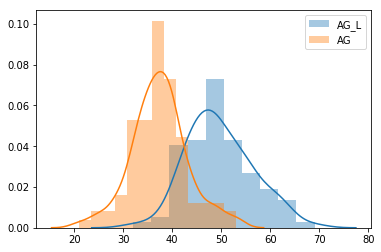

In [449]:
hist_agl = []
hist_ag = []
for i in range(1, 101):
    agl = AG_L(records, pool)
    agl.initialize(25)
    agl.play(975)
    hist_agl.append(agl.rewards)
    agl = AG_L(records, pool)
    agl.initialize(25)
    agl.play(975, 1)
    hist_ag.append(agl.rewards)
    print(i,end='\r',flush=True)
    time.sleep(.001)
sns.distplot(hist_agl, label='AG_L')
sns.distplot(hist_ag, label='AG')
plt.legend()
pass

In [0]:
# offline simulation for UCB_L
def UCB_L(n=1000, c=.005, m=25, r=1, records=records, lives=lives, verbose=True, mode=True):
    # records should be long enough
    '''
    n: number of turns to play
    m: number of turns to initialize
    k: adjust desire to exploit/explore
    mode: whether the modification is active or not
    '''
    def ucb(x):
        # r: ratio between paces of timestamp and turns
        time = records[i]['timestamp']
        article = x[0]
        acc_reward, T = x[1]
        die = lives[article][1]
        s = S.get(article, t)
        if mode:
            return acc_reward/T + c*np.log(r*(die-time)+1) * np.sqrt(2*np.log(t-s+1) / T)
        else:
            return acc_reward/T + np.sqrt(2*np.log(t-s+1)/T)
        
    rewards = 0
    i = 0 # marker in records
    X = {} # dict of expectations article_id : array([sum, n_observations])
    t = 1 # number of turn taken
    S = {} # records the first turn an arm is played
    # initialization
    while t<=m:
        displayed = records[i]['displayed']
        clicked = records[i]['clicked']
        if displayed not in X.keys():
            S[displayed] = t
            X[displayed] = np.array([clicked, 1])
            t += 1
        i += 1
    
    while t<=n:
        while i<len(records):
            fake = False
            displayed = records[i]['displayed']
            clicked = records[i]['clicked']
            
            if displayed not in X.keys(): # use previous mean as an estimation for an unseen arm
                fake = True
                estimation = sum(map(lambda x:x[0]/x[1], X.values())) / len(X) 
                X[displayed] = np.array([estimation, 1])
                            
            best = max(X.items(), key= ucb)
            
            if fake:
                X.pop(displayed)

            if displayed == best[0]:
                rewards += clicked
                if displayed not in S.keys(): # the first time an arm is played
                    S[displayed] = t
                X[displayed] = X.get(displayed, np.array([0, 0])) + np.array([clicked, 1])
                break
            i += 1
            
        if i>=len(records):
            print('running out of records')
            return
        
        if verbose:       
            if i%1000==0:
                print(t,i)
            
        t += 1
        i += 1
    if verbose:
        print('# X', len(X.keys()))
        print('# records', i)
        return rewards, X
    return rewards

In [0]:
# test version 3
# filter young arms before choosing best score
def UCB_L3(n=1000, c=.0005, m=25, p=2, life_threshold=.3, reward_rate=1, records=records, lives=lives, verbose=False, mode=True):
  
    def get_young_arms():
        time = records[i]['timestamp']
        born = filter(lambda x: x[1][0]<time, lives.items()) # fileter out unborn articles from lives
        life_rank = sorted(born, key= lambda x: x[1][1], reverse= True) # sort born articles by their expiring date
        young = life_rank[ : int(len(life_rank)*life_threshold)] # articles among top $life_threshold$% on the life ranking
        return list(zip(*young))[0]
    def ucb(x):
        time = records[i]['timestamp']
        article = x[0]
        acc_reward, T = x[1]
        birth_time, death_time = lives[article]
        if article not in S.keys():
            S[article] = t
        s = S[article]
        if mode:
            life_left = life_est[article] - t + s
            life_spent = t-s

            estimation = acc_reward/T
            life_regulation = c*np.log(life_left+1)
            potential = np.sqrt(p* np.log(life_spent) / T)

            return estimation + life_regulation * potential
        else:
            return acc_reward/T + np.sqrt(p*np.log(t-s)/T)
        
    rewards = 0
    #rewards_log = [0]
    i = 0 # marker in records
    X = {} # dict of expectations article_id : array([sum, n_observations])
    t = 1 # number of turn taken
    S = {} # records the first turn an arm is played
    # initialization
    while t<=m:
        displayed = records[i]['displayed']
        clicked = records[i]['clicked'] * reward_rate
        if displayed not in X.keys():
            S[displayed] = t
            X[displayed] = np.array([clicked, 1])
            if t==1:
                starting_time = records[i]['timestamp']
            t += 1
        i += 1
    
    regrets = 0
    while t<=n:
        rec_used = 0
        while True:
            displayed = records[i]['displayed']
            clicked = records[i]['clicked'] * reward_rate
                
            # initialize all uninitialized arms in the pool with mean of past arms
            tmp = {}
            for article in records[i]['pool']:
                article = article[1:] # items in pool begins with a '|'
                estimation = sum(map(lambda x:x[0]/x[1], X.values())) / len(X) 
                if article not in X.keys():
                    tmp[article] = np.array([estimation, 1])
            
            best = max(# find best among
                filter(# young arms within initialized and uninitialized arms
                    lambda item:item[0] in get_young_arms(),
                    (*X.items(), *tmp.items())
                ),
                key= ucb
            )
            
            if displayed == best[0]:
                rewards += clicked
                if displayed not in S.keys(): # the first turn an arm is played
                    S[displayed] = t
                X[displayed] = X.get(displayed, np.array([0, 0])) + np.array([clicked, 1])
                break
            
            i += 1
            rec_used += 1
    
        t += 1
        i += 1
        #rewards_log.append(rewards)
    #print('regrets',regrets)
    return rewards/reward_rate

In [0]:
life_est = {}
life_length = {}

In [0]:
# test version
def UCB_L2(n=1000, c=.0005, m=25, p=2, reward_rate=1, records=records, lives=lives, verbose=False, mode=True):
    def ucb(x):
        time = records[i]['timestamp']
        article = x[0]
        acc_reward, T = x[1]
        birth_time, death_time = lives[article]
        if article not in S.keys():
            S[article] = t
        s = S[article]
        if mode:
          
            life_left = life_est[article] - t + s
            life_spent = t-s
            
            '''# dynamic ratio from turn to timestamp
            try:
                turn2time = (t-1)/(time-starting_time)
            except ZeroDivisionError:
                turn2time = t-1
            # unborn or dead arms
            if death_time < time or time <= birth_time:
                return 0
            life_left = (death_time - time) * turn2time
            life_spent = (time - birth_time) * turn2time
            # trace estimated life length(in turns)
            if article not in life_length:
                life_length[article] = []
            else:
                life_length[article].append(life_left + life_spent)'''
            
            
            estimation = acc_reward/T
            life_regulation = c*np.log(life_left+1)
            potential = np.sqrt(p* np.log(life_spent) / T)
                      
            '''if verbose:
                print(article, estimation, life_regulation* potential, life_regulation*potential/estimation)'''
                
            return estimation + life_regulation * potential
        else:
            return acc_reward/T + np.sqrt(p*np.log(t-s)/T)
        
    rewards = 0
    #rewards_log = [0]
    i = 0 # marker in records
    X = {} # dict of expectations article_id : array([sum, n_observations])
    t = 1 # number of turn taken
    S = {} # records the first turn an arm is played
    # initialization
    while t<=m:
        displayed = records[i]['displayed']
        clicked = records[i]['clicked'] * reward_rate
        if displayed not in X.keys():
            S[displayed] = t
            X[displayed] = np.array([clicked, 1])
            if t==1:
                starting_time = records[i]['timestamp']
            t += 1
        i += 1
    
    regrets = 0
    log = []
    while t<=n:
        #rec_used = 0
        while True:
            displayed = records[i]['displayed']
            clicked = records[i]['clicked'] * reward_rate
                
            # initialize all uninitialized arms in the pool with mean of past arms
            tmp = {}
            for article in records[i]['pool']:
                article = article[1:] # items in pool begins with a '|'
                estimation = sum(map(lambda x:x[0]/x[1], X.values())) / len(X) 
                if article not in X.keys():
                    tmp[article] = np.array([estimation, 1])
            
            best = max(
                (*X.items(), *tmp.items()),
                key= ucb
            )
            
            if displayed == best[0]:
                log.append((displayed, clicked))

                rewards += clicked
                if displayed not in S.keys(): # the first turn an arm is played
                    S[displayed] = t
                X[displayed] = X.get(displayed, np.array([0, 0])) + np.array([clicked, 1])
                break
              
            
            i += 1
            #rec_used += 1
    
        t += 1
        i += 1
        #rewards_log.append(rewards)
    #print('regrets',regrets)
    res = {'X':X,'rewards':rewards/reward_rate,'t':t,'i':i}

    return res, log

In [33]:
# only remaining life matters
UCB_L2(c=1,reward_rate=.00000000001)['rewards']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt


32.00000000000001

In [32]:
# only current expectation matters
UCB_L2(c=1,reward_rate=1000000000)['rewards']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt


31.0

In [57]:
res_ucb2, log_ucb2 = UCB_L2()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt


In [0]:
res_agl2, log_agl2 = AG_L2(n=1000, verbose=False)

In [62]:
for i in range(len(log_agl2)):
  if log_agl2[i][1] != log_ucb2[i][1]:
    print(i, log_agl2[i], log_ucb2[i])

5 ('id-563643', 1) ('id-563938', 0)
8 ('id-563643', 1) ('id-563938', 0)
67 ('id-563846', 0) ('id-555224', 1)
78 ('id-563643', 0) ('id-555224', 1)
82 ('id-563643', 1) ('id-555224', 0)
85 ('id-563643', 1) ('id-555224', 0)
106 ('id-563643', 1) ('id-555224', 0)
120 ('id-563643', 0) ('id-555224', 1)
124 ('id-563846', 0) ('id-555224', 1)
133 ('id-563643', 0) ('id-555224', 1)
150 ('id-563643', 0) ('id-555224', 1)
151 ('id-563643', 0) ('id-555224', 1)
154 ('id-563643', 0) ('id-555224', 1)
160 ('id-563643', 1) ('id-555224', 0)
165 ('id-563846', 1) ('id-555224', 0)
167 ('id-563846', 1) ('id-555224', 0)
177 ('id-563846', 0) ('id-555224', 1)
180 ('id-563846', 0) ('id-555224', 1)
192 ('id-563643', 0) ('id-555224', 1)
197 ('id-563643', 1) ('id-555224', 0)
201 ('id-563846', 0) ('id-555224', 1)
203 ('id-563643', 0) ('id-555224', 1)
233 ('id-563643', 1) ('id-555224', 0)
237 ('id-563643', 1) ('id-555224', 0)
257 ('id-563846', 1) ('id-555224', 0)
307 ('id-563846', 0) ('id-555224', 1)
329 ('id-563643', 1)

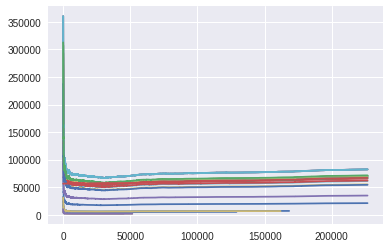

In [43]:
# the estimation for life length(in turns) should be stable
for i in life_length.values():
    plt.plot(i)

In [44]:
life_est={}
for key in life_length:
    life_est[key] = life_length[key][-1]
life_est

{'id-552077': 1693.0,
 'id-555224': 71503.95576318048,
 'id-555528': 70360.01449137191,
 'id-559744': 1984.0,
 'id-559855': 70360.01449137191,
 'id-560290': 70360.01449137191,
 'id-560518': 62066.44027075984,
 'id-560620': 7066.0,
 'id-563115': 65498.264086185525,
 'id-563582': 67214.17599389836,
 'id-563643': 82366.63142339594,
 'id-563787': 1984.0,
 'id-563846': 82366.63142339594,
 'id-563938': 5321.0,
 'id-564335': 55202.792639908475,
 'id-564418': 82366.63142339594,
 'id-564604': 6791.0,
 'id-565364': 21170.539803603773,
 'id-565479': 66928.19067594623,
 'id-565515': 70645.99980932404,
 'id-565533': 66928.19067594623,
 'id-565561': 34897.83506530651,
 'id-565589': 61208.48431690342,
 'id-565648': 70074.02917341978,
 'id-565747': 54344.836686052055,
 'id-565822': 82366.63142339594,
 'id-565930': 61771.87539326913}

In [0]:
ucbl2 = []
for i in range(100):
    ucbl2.append(UCB_L2(n=500, m=20, records=records[i*300:1000000+i*300], verbose=False))
    print(i+1,end='\r',flush=True)
    time.sleep(.0001)

In [0]:
ucbl3 = []
for i in range(100):
    ucbl3.append(UCB_L3(n=500, m=20, records=records[i*300:1000000+i*300], verbose=False))
    print(i+1,end='\r',flush=True)
    time.sleep(.0001)

In [0]:
sns.distplot(ucbl3,label='UCB_L3')
sns.distplot(ucbl2,label='UCB_L2')
sns.distplot(ucbn,label='UCB')
sns.distplot(agl,label='AG_L')
sns.distplot(ag,label='AG')
plt.legend()
pass

In [0]:
# use estimated life length(in turns)
plt.figure(figsize=(10,5))
ts = [.1, .2, .3, .4, .5, .6, .7, .8, .9]
xs = []
ys = []
for t in ts:
    xs.append( 't={}'.format(str(t)) )
    ys.append(UCB_L2(life_threshold=t,records=records, verbose=False))
plt.bar(xs, ys)

In [0]:
# the estimation for life length(in turns) should be stable
for i in life_length.values():
    plt.plot(i)

In [0]:
life_est={}
for key in life_length:
    life_est[key] = life_length[key][-1]
life_est

In [0]:
# use estimated life length(in turns)
plt.figure(figsize=(10,5))
cs = [.0005, .001, .005, .01, .05, .1, .5, 1, 5, 20, 50, 100]
xs = []
ys = []
for c in cs:
    xs.append( 'c={}'.format(str(c)) )
    ys.append(UCB_L2(c=c,records=records[3000:], verbose=False))
plt.bar(xs, ys)

In [0]:
# use estimated life length(in turns)
plt.figure(figsize=(10,5))
cs = [.0005, .001, .005, .01, .05, .1, .5, 1, 5, 20, 50, 100]
xs = []
ys = []
for c in cs:
    xs.append( 'c={}'.format(str(c)) )
    ys.append(UCB_L2(c=c,records=records[1500:], verbose=False))
plt.bar(xs, ys)

In [0]:
# use estimated life length(in turns)
plt.figure(figsize=(10,5))
cs = [.0005, .001, .005, .01, .05, .1, .5, 1, 5, 20, 50, 100]
xs = []
ys = []
for c in cs:
    xs.append( 'c={}'.format(str(c)) )
    ys.append(UCB_L2(c=c, verbose=False))
plt.bar(xs, ys)

In [0]:
# use estimated life length(in turns)
plt.figure(figsize=(10,5))
rs = [10,50,100,200,500,1000,2000,5000,10000]
xs = []
ys = []
for r in rs:
    xs.append( 'r={}'.format(str(r)) )
    ys.append(UCB_L2(reward_rate=r, verbose=False))
plt.bar(xs, ys)

In [0]:
# use estimated life length(in turns)
plt.figure(figsize=(10,5))
rs = [.001, .005, .01, .05, .1, .5, 1, 5, 20, 50, 100]
xs = []
ys = []
for r in rs:
    xs.append( 'r={}'.format(str(r)) )
    ys.append(UCB_L2(reward_rate=r, verbose=False))
plt.bar(xs, ys)

In [0]:
# use estimated life length(in turns)
plt.figure(figsize=(10,5))
cs = [5,10,20,50]
rs = [10,50,100,150]
xs = []
ys = []
for c in cs:
    for r in rs:
        xs.append( 'c{}\nr{}'.format(str(c),str(r)) )
        ys.append(UCB_L2(c=c,reward_rate=r, verbose=False))
plt.bar(xs, ys)

In [0]:
ucbl = []
ucbn = []
for i in range(100):
    ucbl.append(UCB_L(n=500, m=20, r=.8, c=0.005, records=records[i*100:1000000+i*100], verbose=False))
    ucbn.append(UCB_L(n=500, m=20, r=.8, records=records[i*100:1000000+i*100], mode=False, verbose=False))
    print(i,end='\r',flush=True)
    time.sleep(.001)
sns.distplot(ucbl,label='UCB_L')
sns.distplot(ucbn,label='UCB')
plt.legend()
pass